# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [353]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Objectives

The objective of this project is to answer the following questions: 

1- What offers are have the most interactions from customers?

2- Prediction of whether a customer will take an offer based on his/her domegraphic data, such as age, income, or date of joining. 

3- Analysis of the different offer types and the response it gets from customers.

## Data Familirization

In [354]:
# data has already been converted to dataframes from the above cell
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [355]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [356]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [357]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [358]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [359]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [360]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [361]:
transcript.head()
# the value column has to be repaired and extended to different columns

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [362]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


## Data Cleaning and Preparation

From the above quick data exploration, we have found some issues to be fixed. Will go over them in the following cells.

* one-hot encoded the channel column
* mapping id for users in profile and transcript datasets
* mapping offer id for offers in portfolio dataset
* combine profile and transcript datasets, based on user id
* remove all rows with null values

In [363]:
# Distributing the channels in portfolio over different columns
temp_df = pd.Series(portfolio['channels'].tolist()).apply(frozenset).to_frame(name='temp_ch')
for ch in frozenset.union(*temp_df.temp_ch):
    temp_df[ch] = temp_df.apply(lambda _: int(ch in _.temp_ch), axis=1)

# source https://datascience.stackexchange.com/questions/11797/split-a-list-of-values-into-columns-of-a-dataframe

portfolio = portfolio.join(temp_df)
portfolio.drop(['channels', 'temp_ch'], axis = 1, inplace = True)
portfolio.head()

,difficulty,duration,id,offer_type,reward,social,web,mobile,email
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1


In [364]:
# Mapping ids in portfolio and profile dataframes. Also mapping the new ids to transcript
def id_mapper(df_column, st):
    coded_dict = dict()
    cter = 1
    column_id_encoded = []
    
    for val in df_column:
        if val not in coded_dict:
            coded_dict[val] = st + str(cter)
            cter+=1
        
        column_id_encoded.append(coded_dict[val])
        
    return column_id_encoded, coded_dict

In [365]:
# Modifying offer id in portfolio dataset
# it'll start with 'O' then a counter
offer_id_encoded, offer_id_coded_dict = id_mapper(portfolio['id'], 'O')
portfolio['offer_id'] = offer_id_encoded
del portfolio['id']

In [366]:
# Modifying user id in profile dataset
# it'll start with 'U' then a counter
user_id_encoded, user_id_coded_dict = id_mapper(profile['id'], 'U')
profile['user_id'] = user_id_encoded
del profile['id']

In [367]:
# modifying person and value columns ids in transcript dataset
# person column; change the name as well
transcript['user_id'] = transcript['person'].apply(lambda x: user_id_coded_dict[x])
del transcript['person']
# value column
for value in transcript['value']:
    if 'offer id' in value:
        value['offer id'] = offer_id_coded_dict[value['offer id']]
    elif 'offer_id' in value:
        value['offer_id'] = offer_id_coded_dict[value['offer_id']]


In [368]:
# merge profile and transcript datasets based on user_id
new_transcript_profile = transcript.merge(profile, on = 'user_id', how = 'inner')

In [369]:
# remove all rows with null values
new_transcript_profile.dropna(inplace = True)

In [370]:
new_transcript_profile['event'].value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

Currently we've two main dataframes:

1- new_transcript_profile

2- portfolio

In [371]:
new_transcript_profile.head(10)

,event,time,value,user_id,age,became_member_on,gender,income
0,offer received,0,{'offer id': 'O4'},U4,75,20170509,F,100000.0
1,offer viewed,6,{'offer id': 'O4'},U4,75,20170509,F,100000.0
2,transaction,132,{'amount': 19.89},U4,75,20170509,F,100000.0
3,offer completed,132,"{'offer_id': 'O4', 'reward': 5}",U4,75,20170509,F,100000.0
4,transaction,144,{'amount': 17.78},U4,75,20170509,F,100000.0
5,offer received,168,{'offer id': 'O8'},U4,75,20170509,F,100000.0
6,offer viewed,216,{'offer id': 'O8'},U4,75,20170509,F,100000.0
7,transaction,222,{'amount': 19.67},U4,75,20170509,F,100000.0
8,transaction,240,{'amount': 29.72},U4,75,20170509,F,100000.0
9,transaction,378,{'amount': 23.93},U4,75,20170509,F,100000.0


In [372]:
portfolio.head(10)

,difficulty,duration,offer_type,reward,social,web,mobile,email,offer_id
0,10,7,bogo,10,1,0,1,1,O1
1,10,5,bogo,10,1,1,1,1,O2
2,0,4,informational,0,0,1,1,1,O3
3,5,7,bogo,5,0,1,1,1,O4
4,20,10,discount,5,0,1,0,1,O5
5,7,7,discount,3,1,1,1,1,O6
6,10,10,discount,2,1,1,1,1,O7
7,0,3,informational,0,1,0,1,1,O8
8,5,5,bogo,5,1,1,1,1,O9
9,10,7,discount,2,0,1,1,1,O10


## Analysis and Visualization

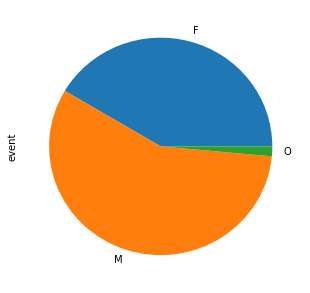

In [373]:
# Gender categrization of offers
new_transcript_profile.groupby(['gender']).count()['event'].plot.pie(figsize = (5,5))

# Men are slightly higher than femals; on the other hand, 'O' category is the minority

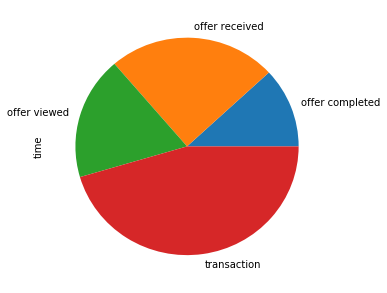

In [374]:
# percentage of offers completed, viewed, received, and just transcation
new_transcript_profile.groupby(['event']).count()['time'].plot.pie(figsize = (5,5))

Text(0.5,1,'The overall age distribution')

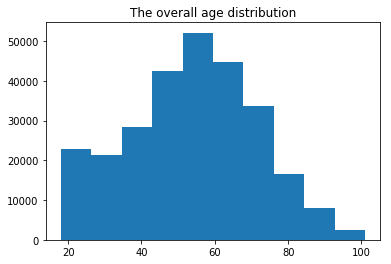

In [375]:
plt.hist(new_transcript_profile.age)
plt.title('The overall age distribution')

(array([ 15923.,  14333.,  18239.,  21282.,  28437.,  27613.,  16181.,
          8946.,   3611.,   1125.]),
 array([  18. ,   26.2,   34.4,   42.6,   50.8,   59. ,   67.2,   75.4,
          83.6,   91.8,  100. ]),
 <a list of 10 Patch objects>)

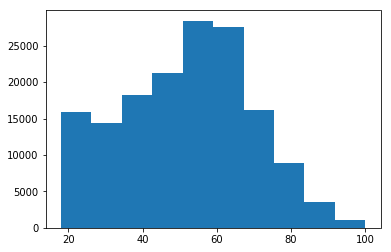

In [376]:
# male age distribution
plt.hist(new_transcript_profile[new_transcript_profile['gender'] == 'M']['age'])

(array([  6732.,   6806.,   9768.,  16834.,  23085.,  19926.,  15448.,
          8349.,   4651.,   1502.]),
 array([  18. ,   26.3,   34.6,   42.9,   51.2,   59.5,   67.8,   76.1,
          84.4,   92.7,  101. ]),
 <a list of 10 Patch objects>)

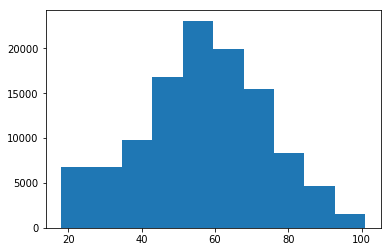

In [377]:
# female age distribution
plt.hist(new_transcript_profile[new_transcript_profile['gender'] == 'F']['age'])

As it can be seen from above, younger males are interacting more with starbucks compared to younger females

In [378]:
# split the data into three dataframes, offer_received, offer_completed, and offer_viewed

# offer viewed
offer_viewed = new_transcript_profile[new_transcript_profile['event'] == 'offer viewed']
viewed_id_list = []
for offer in offer_viewed['value']:
    viewed_id_list.append(offer['offer id'])

offer_viewed['value'] = viewed_id_list

# offer_completed
offer_completed = new_transcript_profile[new_transcript_profile['event'] == 'offer completed']
completed_id_list = []
completed_id_reward = []

for offer in offer_completed['value']:
    completed_id_list.append(offer['offer_id'])
    completed_id_reward.append(offer['reward'])

offer_completed['value'] = completed_id_list
offer_completed['reward'] = completed_id_reward


# offer received
offer_received = new_transcript_profile[new_transcript_profile['event'] == 'offer received']
received_id_list = []
for offer in offer_received['value']:
    received_id_list.append(offer['offer id'])

offer_received['value'] = received_id_list

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

In [379]:
# find the top five offers that users view, complete, and view
print('viewed:\n', offer_viewed['value'].value_counts()[:5])
print('completed:\n', offer_completed['value'].value_counts()[:5])
print('received:\n', offer_received['value'].value_counts()[:5])

viewed:
 O7    6407
O6    6379
O2    6329
O9    6310
O1    5901
Name: value, dtype: int64
completed:
 O7     5003
O6     4886
O4     4188
O9     4103
O10    3911
Name: value, dtype: int64
received:
 O5    6726
O4    6685
O1    6683
O3    6657
O6    6655
Name: value, dtype: int64


From the above analysis, we can tell that Offer7 is being viewed the most and at the same time it's being completed the most. It's interesting how this offer isn't being received the most. So there's something appealing about this offer. Offer 4 on the other hand, is being rceived quite a lot of times, and it's being completed a lot of times as well. This means, most of those who see offer 4 complete it. 

## Model

In [380]:
# This model will preict whether someone, who's received an offer, will complete it or not. 

#importing what's needed for the machine learning model
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

In [381]:
# We'll only keep rows with events of "offer received" or "offer completed"
model_dataframe = pd.concat([offer_received, offer_completed], axis = 0, sort = False, ignore_index = True)

In [382]:
# coding the output model
# 0 for offer received and 1 for offer completed
model_dataframe.replace({'offer received':0, 'offer completed':1}, inplace = True)

In [383]:
# replace F with 0 and M with 1 in gender dataframe
model_dataframe.replace({'F':0, 'M':1, 'O':0}, inplace = True)

In [384]:
# shuffle the dataframe to ensure good split
model_dataframe.sample(frac = 1).head(10)

,event,time,value,user_id,age,became_member_on,gender,income,reward
88811,1,420,O7,U15097,55,20170625,1,60000.0,2.0
66485,0,504,O8,U16894,75,20170529,1,116000.0,NaN
55841,0,504,O4,U11706,64,20171204,1,88000.0,NaN
66349,0,408,O4,U16094,58,20140422,1,68000.0,NaN
66910,1,210,O5,U275,81,20160601,1,70000.0,5.0
69,0,576,O6,U34,96,20171117,0,89000.0,NaN
35350,0,0,O7,U11617,88,20170812,0,50000.0,NaN
58656,0,336,O5,U14456,64,20141222,1,86000.0,NaN
59608,0,168,O2,U15561,24,20170220,1,56000.0,NaN
13038,0,168,O8,U4353,23,20161130,0,70000.0,NaN


In [385]:
# for our model, 
# x (features) will be age, time, gender, and income columns
# y (outcome) will be event column
X = model_dataframe[['age', 'gender', 'income']]
y = model_dataframe[['event']]

In [386]:
# splitting training and testing datassets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 19)

In [387]:
# scalling and transforming
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [388]:

# Training the model
model = AdaBoostClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [389]:
# finding the accuracy of the model
print('accuracy : ' , accuracy_score(y_test, preds))

# printing classification report
print(classification_report(y_test, preds, target_names=['received offer', 'completed offer']))


accuracy :  0.671686290363
                 precision    recall  f1-score   support

 received offer       0.67      1.00      0.80     13292
completed offer       0.00      0.00      0.00      6497

    avg / total       0.45      0.67      0.54     19789



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [390]:
# from the above, it looks like that the model was able to accurately predict whether someone has received or completed an offer based on the given features


In [391]:
feature_importance = pd.DataFrame(model.feature_importances_, index = X.columns)
feature_importance = feature_importance[feature_importance != 0]
feature_importance = feature_importance.dropna()
feature_importance


,0
age,0.36
gender,0.04
income,0.60


In [392]:
# in coclusion, we can see that the biggest factor in determining whether someone will receive an offer is the time of the offer